## Class that incorporates the algebraic method for finding the conductance matrices

In [2]:
# all imports

import hypernetx as hnx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import warnings 

warnings.simplefilter('ignore')

from sympy import *

init_printing()




In [2]:


# Define our class:

class ModuleProperties:

    """ Class to define a reaction module, with methods to find hypergraphs, reaction cycles,
    
    Attributes:
        SM (Sympy Matrix): Stoichiometric Matrix of the reaction module
        num_internal_species (int): Number of internal species in the reaction module
        species_labels (dict): Labels for the species in the reaction module for hypergraph

    Methods:
        hypergraph_internals(): Generates and displays the hypergraph for internal species of the stoichiometric matrix
        hypergraph_full(): Generates and displays the hypergraph for the full stoichiometric matrix
        reaction_cycles_matrix(): Computes the reaction level cycles matrix for internal species
        coupling_matrix(): Computes the coupling matrix between internal and external species
        conservation_laws(): Computes the conservation law matrices for the full stoichiometric matrix and the chemostat species
        calculate_resistance_matrix(): Computes the reaction level resistance matrix for the module with sympy labelling of reactions
    """
    
    

    #==========================================================================================================================================
    # INIT
    #

    def __init__(self, SM, num_internal_species, species_names):

        """ Initializes the ModuleProperties class with the full stoichiometric matrix, the internal and external stoichiometric matrices,
        and the labels of the species, reactions, forces, chemical potentials."""

        self.matrix = SM # Returns the passed SM, ready for print

        self.internal_SM = SM[0:num_internal_species, :] # finds the internal species SM by selecting the number of rows needed

        self.external_SM = SM[num_internal_species: len(SM), :] # finds SM for external species using remaning rows after internal species

        self.hypergraph_labels = dict(enumerate(species_names)) # for the hypergraphs

        
        # LABELLING FOR SPECIES, FORCES, EDGE CURRENTS, CHEMICAL POTENTIALS

        #self.species_labels = []

        self.chemical_potentials = []

        num_rows = self.matrix.rows
        

        for n in range(num_rows):
            
            #species_symbol = species_names[n]
            species_symbol = symbols(species_names[n])
            #self.species_labels.append(species_symbol)

            chem_pot = symbols(f"\mu_{species_symbol}")
            self.chemical_potentials.append(chem_pot)
            

        self.chemical_potentials_vector = Matrix(self.chemical_potentials).T  # make a vector out of the labelled chemical potentials
        
        # LABELS FOR ALL RESISTANCES AND REACTIONS

        num_cols = self.matrix.cols # Finds number of columns ( == no. of reactions) in the SM
       
        resistances = [] # define list to hold reaction labels
        edge_currents_j = [] # to hold the js
        forces = [] # to hold reaction level forces

        for n in range(num_cols): # loop over each reaction

            nth_resistance = symbols(f"r{n+1}") # assign name of nth resistance
            resistances.append(nth_resistance) # add to list of resistance

            nth_edge_currents_j = symbols(f"j{n+1}") # assign name of nth edge current
            edge_currents_j.append(nth_edge_currents_j) # add to list of currents

            reaction_vector = -1* self.matrix[:,n] # take the column of SM that corresponds to nth reaction
            
            forces.append(self.chemical_potentials_vector*reaction_vector) # use reaction vector *-1  in SM to create forces in terms of chem potentials
        
        
        self.force_vector = Matrix(forces) # create a vector of reaction level forces
        self.edge_currents_vector = Matrix(edge_currents_j) # make a vector out of the js


        # reaction resistance in terms of r = f/j

        reaction_level_res = [] # to hold reaction level resistances

        for n in range(num_cols): # loop over each reaction

            symbolic_resistance = self.force_vector[n] / self.edge_currents_vector[n]

            reaction_level_res.append(symbolic_resistance)

        self.kinetic_form_resistance_matrix = Matrix.diag(reaction_level_res) # output reaction level res. matrix in terms of r = f/j
        

        # SIMPLIFIED CURRENTS USING STEADY STATE CONDITION

        current_vector = self.edge_currents_vector

        new_vector = Matrix(current_vector) # placeholder for now

        product = self.internal_SM * current_vector # apply steady state

        elements = []
        for element in current_vector:

            elements.append(element)

        solutions = list( solve(product, (elements)).items()) # solve steady state as dict and store outcome

        # Substitute the relations to find the simplest expression
        simplified_j = new_vector.subs([(rel[0], rel[1]) for rel in solutions])

        # Further simplify if possible
        self.simplified_j = simplify(simplified_j)

        self.edge_currents_j = self.simplified_j

        
        
        
    #==========================================================================================================================================
    # HYPERGRAPHS
    #
    # Define a new function to find the hypergraphs for the internal species
    #

    def hypergraph_internals(self):

        """ This method generates and displays the hypergraph for the internal species of the module using the node
        labels defined in self.
        """

        internals_HG = hnx.Hypergraph.from_incidence_matrix(self.internal_SM) # create hypergraph, using the internal SM defined in self

        hnx.draw(internals_HG, node_labels=self.hypergraph_labels, with_edge_labels=True) # print this using the labels defined in self

    #
    # Define a new function to find the hypergraphs for the full stoichiometric matrix
    #

    def hypergraph_full(self):
        
        """ This method generates and displays the hypergraph for the full stoichiometric matrix of the module using the node
        labels defined in self.
        """

        full_HG = hnx.Hypergraph.from_incidence_matrix(self.matrix) # create hypergraph, using the full SM defined in self

        hnx.draw(full_HG, node_labels=self.hypergraph_labels, with_edge_labels=True) # print this using the labels defined in self

    #==========================================================================================================================================
    # REACTION LEVEL CYCLES
    #

    def calculate_reaction_cycles_matrix(self):

        """ This method calculates the reaction level cycles matrix for the internal species of the module using the 
        kernel of the internal stoichiometric matrix.
        
        Returns:
            cycle_matrix (Sympy Matrix): Reaction level cycles matrix for internal species
        """
        
        reaction_cycles = (self.internal_SM).nullspace() # finds the kernel for the SM internal

        # Check if there are any cycles:

        if not reaction_cycles:

            print("No internal cycles. Kernel is empty.")

        # build cycle matrix from kernel vectors if kernel is NOT empty

        else:

            cycle_matrix = reaction_cycles[0] # add first vector to cycle matrix so we can add rest later
            
            for cycle in reaction_cycles[1:]: # starting at second vector in kernel

                cycle_matrix = cycle_matrix.row_join(cycle) # connect vectors from kernel column-wise, row_join puts elemetns of adjacent vectors together


            self.cycle_matrix = cycle_matrix # assign cycle matrix to self for use in other methods
            
            return cycle_matrix # return the cycle matrix
        
    #==========================================================================================================================================
    # COUPLING MATRICES
    #  

    def calculate_coupling_matrix(self):

        """ This method calculates the coupling matrix between internal and external species using reaction cycle matrix 
        and SM of external species.

        Returns:
            phi (Sympy Matrix): Coupling matrix between internal and external species
        """

        phi = self.external_SM * self.calculate_reaction_cycles_matrix()

        self.phi = phi
        return phi


    #==========================================================================================================================================
    # CONSERVATION LAW MATRICES
    #
    def calculate_conservation_laws(self):

        """ This method calculates the conservation law matrices for the full stoichiometric matrix and the chemostat species only.
        
        Returns:
            cons_laws.T (Sympy Matrix): Conservation law matrix for the full stoichiometric matrix  
            chemostat_laws.T (Sympy Matrix): Conservation law matrix for the chemostat species only
        """

        cokernel_SM = (self.matrix.T).nullspace() # finds the cokernel of the full SM

        if not cokernel_SM:

            print("No conservation laws. Cokernel of Stoichiometric Matrix empty.")

        else:

            cons_laws = cokernel_SM[0] # adds first element of cokernel

            for vec in cokernel_SM[1:]: # add vectors from next row onwards

                cons_laws = cons_laws.row_join(vec)


        #
        # Broken external laws for chemostat , deriving from the coupling matrix
        #

        coupling_matrix = self.calculate_coupling_matrix() # define the coupling matrix using the function defined previously

        cokernel_coupling_matrix = coupling_matrix.T.nullspace() # find the cokernel of the coupling matrix

        if not cokernel_coupling_matrix:

            print("No chemostat conservation laws. Cokernel of Coupling Matrix is empty.")

        # if cokernel is NOT empty

        else:

            chemostat_laws = cokernel_coupling_matrix[0] # add first vector to chemostat conservation law matrix so we can add rest later

            for law in cokernel_coupling_matrix[1:]: # starting at second vector in kernel

                chemostat_laws = chemostat_laws.row_join(law) # connect vectors from kernel column-wise, row_join puts elemetns of adjacent vectors together



        self.cons_laws = cons_laws.T # assign to self for use in other methods
        self.chemostat_laws = chemostat_laws.T # assign to self for use in other methods

        return cons_laws.T, chemostat_laws.T # return transpose to match equations in paper { L^(1) and l^(1) respectively}
    
    #==========================================================================================================================================
    # REACTION LEVEL RESISTANCE MATRIX
    #
    
    def calculate_reaction_resistance_matrix(self):

        """ Calculates the reaction level resistance matrix for the module, including an auto-labelling of reactions in the SM 
        according to the number of columns in the SM for use in Sympy operations."""
        
        

        num_cols = self.matrix.cols # Finds number of columns ( == no. of reactions) in the SM

        resistances = [] # define list to hold reaction labels
    
        for n in range(num_cols):

            nth_reaction = symbols(f"r{n+1}") # assign name of nth reaction

            resistances.append(nth_reaction) # add to list of reactions


    
        resistance_matrix = Matrix.diag(resistances) # create diagonal matrix from list of reactions

        self.resistance_matrix = resistance_matrix # assign to self for use in other methods

        return resistance_matrix
        
        
        
    #==========================================================================================================================================
    # CYCLE RESISTANCE MATRIX
    #

    def calculate_cycle_resistance_matrix(self):

        """ Uses the reaction level resistance matrix and reaction cycles matrix to calculate the cycle resistance matrix for the module.
        
        Returns:
            cycle_resistance_matrix (Sympy Matrix): Cycle resistance matrix for the module"""

        cycle_resistance_matrix = self.calculate_reaction_cycles_matrix().T * self.calculate_reaction_resistance_matrix() * self.calculate_reaction_cycles_matrix()

        return cycle_resistance_matrix
    
    #==========================================================================================================================================
    # CONDUCATANCE MATRICES
    #

    def calculate_physical_conductance_matrix(self):

        """Calculates the physical conductance matrix g using the coupling matrix and resistance matrix
        
        Returns:
            physical_conductance_matrix (Sympy Matrix): The physical conductance matrix for the module"""

        physical_conductance_matrix = self.calculate_coupling_matrix() * self.calculate_cycle_resistance_matrix().inv() \
          * self.calculate_coupling_matrix().T        

        
        return physical_conductance_matrix


    #==========================================================================================================================================
    # REACTION CURRENTS
    #

    def calculate_physical_currents(self):

        """Calculates the physical currents (between the chemostats of the module) using the reaction current vector dervied from the steady-state
        condition
        
        Returns:
            currents (Sympy Matrix): Vector of independent external currents """

        currents = -1* self.external_SM * self.simplified_j

        return currents

    #==========================================================================================================================================
    #   FUNDAMENTAL CONDUCTANCE MATRIX
    #
    
    def calculate_fundamental_conductance_matrix(self):

        """Calculats the fundamental conductance matrix for the module, building the selection matrix from the kernel of the chemostat conser
        -vation laws, finding the pseudoinverse for this matrix and using the physical conductance matrix
        
        Returns:
            fundamental_CM (Sympy Matrix): Fundamental conductance matrix for the module"""
        

        cons_laws_kernel = self.calculate_conservation_laws()[1].nullspace() 

        
        if not cons_laws_kernel:

            print("No selection matrix calculated. Kernel of chemostat conservation laws matrix is empty.")
    
        result = cons_laws_kernel[0]

        for i in range(1,len(cons_laws_kernel)):
            
            result = result.row_join(-1*cons_laws_kernel[i]) # *-1 here to put matter flow in correct direction

        selection_matrix = result

        selection_matrix_MPI = (selection_matrix.T*selection_matrix).inv() * selection_matrix.T

        

        fundamental_CM = selection_matrix_MPI * self.calculate_physical_conductance_matrix() * selection_matrix_MPI.T

        return fundamental_CM



    

        



In [251]:
SM_1 = Matrix( [[-1, 1, 0], [1, -1, -1], [0, 0, 1], [-1, 0, -1], [0, 1, 0]] ) # The SM of module 1

num_internal_species = 3 # for extracting the internal and external SMs

#labels = {0: 'Ea', 1: 'EaS', 2: 'EaS2', 3: 'S', 4: 'Na'}
species_names1 = ["Ea", "EaS", "EaS2", "S", "Na"]

mod1 = ModuleProperties(SM_1, num_internal_species, species_names1)

mod1.calculate_fundamental_conductance_matrix()

mod1.calculate_cycle_resistance_matrix()


[r₁ + r₂]

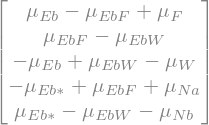

In [52]:
stoich_matrix_2 = Matrix([[-1, 0, 1, 0, 0], # first row of internal
                           [1, -1, 0, -1, 0], 
                           [0, 1, -1, 0, 1], 
                           [0, 0, 0, 1, -1],
                             [0, 0, 0, -1, 0], # first row external 
                             [0, 0, 0, 0, 1],
                             [-1, 0, 0, 0, 0],
                             [0, 0, 1, 0, 0]])



species_names2 = ["Eb", "EbF", "EbW", "Eb*", "Na", "Nb", "F", "W"]


mod2 = ModuleProperties(stoich_matrix_2, 4,species_names2)

mod2.internal_SM * mod2.calculate_reaction_cycles_matrix() 

C_paper = Matrix([[0,-1,0,1,1], [1,1,1,0,0]]).T # C^(2) from eq(53)
C_paper

mod2.calculate_cycle_resistance_matrix()
mod2.calculate_fundamental_conductance_matrix() * mod2.calculate_cycle_resistance_matrix().det()


In [253]:
mod2.calculate_physical_conductance_matrix() * mod2.calculate_cycle_resistance_matrix().det()

⎡r₁ + r₂ + r₃   -r₁ - r₂ - r₃       r₂             -r₂     ⎤
⎢                                                          ⎥
⎢-r₁ - r₂ - r₃  r₁ + r₂ + r₃        -r₂            r₂      ⎥
⎢                                                          ⎥
⎢     r₂             -r₂       r₂ + r₄ + r₅   -r₂ - r₄ - r₅⎥
⎢                                                          ⎥
⎣     -r₂            r₂        -r₂ - r₄ - r₅  r₂ + r₄ + r₅ ⎦

In [254]:
mod2.calculate_cycle_resistance_matrix().inv() * mod2.calculate_cycle_resistance_matrix().det()

⎡r₂ + r₄ + r₅       r₂     ⎤
⎢                          ⎥
⎣     r₂       r₁ + r₂ + r₃⎦

In [ ]:


# LABELS FOR ALL SPECIES AND CHEMICAL POTENTIALS

SM_1 = Matrix( [[-1, 1, 0], [1, -1, -1], [0, 0, 1], [-1, 0, -1], [0, 1, 0]] ) # The SM of module 1

species_names = ["Ea", "EaS", "EaS2", "S", "Na"] # species for module 1 in latex notation
species_labels = []

chemical_potentials = []

num_rows = 5 #self.matrix.rows

for n in range(num_rows):
    
    species_symbol = species_names[n]
    species_symbol = symbols(species_symbol)
    species_labels.append(species_symbol)

    chem_pot = symbols(f"\mu_{species_symbol}")
    chemical_potentials.append(chem_pot)
    

edge_currents_vector = Matrix([edge_currents_j]) # make a vector out of the js
chemical_potentials_vector = Matrix([chemical_potentials]) # make a vector out of the labelled chemical potentials




# LABELS FOR ALL RESISTANCES AND REACTIONS

num_cols = 3 #self.matrix.cols # Finds number of columns ( == no. of reactions) in the SM

resistances = [] # define list to hold reaction labels
edge_currents_j = []
forces = []

for n in range(num_cols):

    nth_resistance = symbols(f"r{n+1}") # assign name of nth resistance
    resistances.append(nth_resistance) # add to list of resistance

    nth_edge_currents_j = symbols(f"j{n+1}") # assign name of nth resistance
    edge_currents_j.append(nth_edge_currents_j) # add to list of resistance

    reaction_vector = -1* SM_1[:,n] #self.matrix[:,n]
    
    forces.append(chemical_potentials_vector*reaction_vector) # use reaction vector *-1  in SM to create forces in terms of chem potentials
    
force_vector = Matrix([forces]).T



# reaction resistance in terms of r = f/j

reaction_level_res = []

for n in range(num_cols):

    symbolic_resistance = force_vector[n] / edge_currents_vector[n]

    reaction_level_res.append(symbolic_resistance)

kinetic_form_resistance_matrix = Matrix([reaction_level_res])




In [ ]:
# Need a method for solving the steady state

# steady state condition is: stoich_X * _j = 0

SM_X = mod1.internal_SM

current_vector = mod1.edge_currents_vector

new_vector = Matrix(current_vector) # placeholder for now

product = SM_X * current_vector # apply steady state

elements = []
for element in current_vector:

    elements.append(element)


solution = list( solve(product, (elements)).items()) # solve steady state as dict and store outcome


# Create the current vector _j


# Substitute the relations to find the simplest expression
simplified_j = new_vector.subs([(rel[0], rel[1]) for rel in solution])

# Further simplify if possible
simplified_j = sp.simplify(simplified_j)


simplified_j



⎡j₂⎤
⎢  ⎥
⎢j₂⎥
⎢  ⎥
⎣0 ⎦

In [ ]:
SM_X2 = mod2.internal_SM

current_vector2 = mod2.edge_currents_vector

new_vector2 = Matrix(current_vector2) # placeholder for now

product2 = SM_X2 * current_vector2 # apply steady state

#solution2 = list( solve(product2, (current_vector2[0],current_vector2[1],current_vector2[2])).items()) # solve steady state as dict and store outcome

product2

#elements2 = []
#for i in range(len(product2)):#
#
#    elements2.append(product2[i])

#solution2 = solve(product2, elements2)

solution2 = list( solve(product2, (current_vector2[0],current_vector2[1],current_vector2[2],current_vector2[3])).items())

solution2

In [ ]:


# Your given relations
solution2 = solution2

# Create the current vector _j
new_vector2 = new_vector2

# Substitute the relations to find the simplest expression
simplified_j = new_vector2.subs([(rel[0], rel[1]) for rel in solution2])

# Further simplify if possible
simplified_j = sp.simplify(simplified_j)


simplified_j

⎡  j₃   ⎤
⎢       ⎥
⎢j₃ - j₅⎥
⎢       ⎥
⎢  j₃   ⎥
⎢       ⎥
⎢  j₅   ⎥
⎢       ⎥
⎣  j₅   ⎦